In [9]:
import numpy as np
import time
from numpy import *
from scipy import io

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy import integrate

import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.preprocessing import PolynomialFeatures

import sys
sys.path.append("../")

from spline import splineBasis
from ado import * 

from pysindy.differentiation import SmoothedFiniteDifference

# Generate multiple sparse and noisy measurement datasets

In [10]:
sample_ratio = 0.2

sample_idx_lst = []
t_m_lst = []

for i in range(4):
    np.random.seed(i)
    sample_idx = sorted(np.random.choice(len(t_m_all), int(len(t_m_all) * sample_ratio), replace=False))
    sample_idx_lst.append(sample_idx)
    t_m_lst.append(t_m_all[sample_idx])


lorenz_x = '10*y - 10*x'
lorenz_y = '28*x - x*z - y'
lorenz_z = 'x*y - 8/3 * z'

def lorenz(x_y_z, t):
    x, y, z = x_y_z
    return [eval(lorenz_x), eval(lorenz_y), eval(lorenz_z)]

x0_lst = [[-8, 7, 27], [-4, 6, 2], [5, 8, 20], [8, -2, 10]]

data_true = []
der_true = []
data_noise = []

t_m_all = np.linspace(0, 20, 2001)

for s in range(4):

    np.random.seed(s+1)
    # initial condition 
    x0 = x0_lst[s]

    t = t_m_all
    x_t = integrate.odeint(lorenz, x0, t)

    x_true = x_t[:, 0]
    y_true = x_t[:, 1]
    z_true = x_t[:, 2]
    x = x_true
    y = y_true
    z = z_true
    eq1_true = np.array(eval(lorenz_x))
    eq2_true = np.array(eval(lorenz_y))
    eq3_true = np.array(eval(lorenz_z))
    
    data_true.append(x_t)
    der_true.append(np.vstack([eq1_true, eq2_true, eq3_true]).transpose())

    # add random noise to ode45 generated data with a certain noise ratio 
    # and randomly extract the cetrain amount of data used for training 
    # (actually x_test is not going to be used)
    n_ratio = 0.05

    x_n = np.random.normal(0,1,len(t))
    x_n = x_n / np.std(x_n)
    x_noise = x_true + n_ratio * np.sqrt(np.mean(x_true**2)) * x_n
    x_train = x_noise[sample_idx_lst[s]]

    y_n = np.random.normal(0,1,len(t))
    y_n = y_n / np.std(y_n)
    y_noise = y_true + n_ratio * np.sqrt(np.mean(y_true**2)) * y_n
    y_train = y_noise[sample_idx_lst[s]]

    z_n = np.random.normal(0,1,len(t))
    z_n = z_n / np.std(z_n)
    z_noise = z_true + n_ratio * np.sqrt(np.mean(z_true**2)) * z_n
    z_train = z_noise[sample_idx_lst[s]]

    data_noise.append(np.vstack([x_train, y_train, z_train]).transpose())

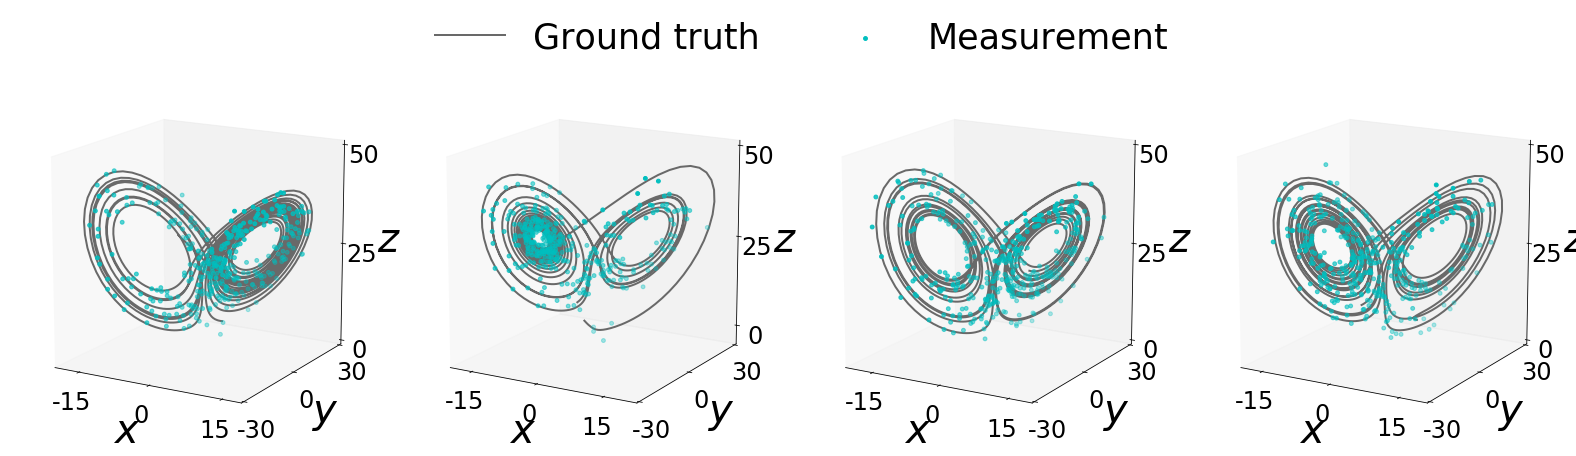

In [12]:
from matplotlib import rcParams
rcParams['axes.labelpad'] = 12

fig = plt.figure(figsize=(28, 7))

for s in range(4):

    ax = fig.add_subplot(1,4,s+1, projection="3d")
    ax.plot(data_true[s][:, 0], data_true[s][:, 1], data_true[s][:, 2], lw=2, c='dimgrey', label='Ground truth')
    ax.scatter(data_noise[s][:, 0], data_noise[s][:, 1], data_noise[s][:, 2], c='c', s=15, label='Measurement')
        
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.tick_params(pad=5)
    ax.set_xlabel('$x$', fontsize=40)
    ax.set_xticks(arange(-15, 16, 15))
    ax.set_xticklabels(arange(-15, 16, 15), fontsize=24)
    ax.set_ylabel('$y$', fontsize=40)
    ax.set_yticks(arange(-30, 31, 30))
    ax.set_yticklabels(arange(-30, 31, 30), fontsize=24) 
    ax.set_zlabel('$z$', fontsize=40)
    ax.set_zticks(arange(0, 51, 25))
    ax.set_zticklabels(arange(0, 51, 25), fontsize=24)
    ax.view_init(15)
    if s == 0: plt.legend(fontsize=35, ncol=2, frameon=False, loc=(1.1,1.00))


plt.subplots_adjust(wspace=0.05, hspace=0.2)
plt.show()

# Physics-informed Spline Learning

build cubic B-spline model 

In [9]:
# define time domain: 0-20s measurement sampling rate 100/s, collocation sampling rate 1000/s

t = np.linspace(0, 20, 1001)
knots = np.array([0,0,0,] + list(t) + [20,20,20])

t_m_all = np.linspace(0, 20, 2001)
t_c = np.linspace(0, 20, 20001)

basis = splineBasis(knots, t_m, t_c)
basis_m_all, basis_dt_m_all = basis.get_measurement()
basis_c, basis_dt_c = basis.get_collocation()

basis_m_lst = []
for i in range(4):
    sample_index = sample_idx_lst[i]
    basis_m_lst.append(basis_m_all[sample_idx, :])

pre-tuning

In [9]:
import torch
from torch import *
from torch.optim.lr_scheduler import ReduceLROnPlateau

import time

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()


poly_degree = 3

X = np.arange(poly_degree * 3).reshape(poly_degree, 3)
poly = PolynomialFeatures(poly_degree)
poly.fit_transform(X)
raw_poly = poly.get_feature_names(input_features=['x', 'y', 'z'])
polynomial_library = [p.replace(' ', '*').replace('^', '**') for p in raw_poly]



t_m_len1 = len(t_m_lst[0])
t_m_len2 = len(t_m_lst[1])
t_m_len3 = len(t_m_lst[2])
t_m_len4 = len(t_m_lst[3])

t_c_len = basis_c.shape[0]
num_control = basis_m_all.shape[1]
num_term = len(polynomial_library)

# create a function that will be evaluated while training 
# this function is constructed with unknown parameters {cxi, cyi, czi}, i=0,1,....num_terms
function_x = 'cx0*1'
function_y = 'cy0*1'
function_z = 'cz0*1'

for i in range(1, num_term):
    term = polynomial_library[i]
    function_x += ('+cx'+str(i)+'*'+term)
    function_y += ('+cy'+str(i)+'*'+term)
    function_z += ('+cz'+str(i)+'*'+term)
    
# convert the basis matrices to tensors 
N1 = torch.Tensor(basis_m_lst[0]).to(device)
N2 = torch.Tensor(basis_m_lst[1]).to(device)
N3 = torch.Tensor(basis_m_lst[2]).to(device)
N4 = torch.Tensor(basis_m_lst[3]).to(device)

N_c = torch.Tensor(basis_c).to(device)
N_dt = torch.Tensor(basis_dt_c).to(device)

# this is matrics that multiply to get the column of specific state variables x, y, z
get_x = torch.Tensor(np.array([1, 0, 0])).to(device)
get_y = torch.Tensor(np.array([0, 1, 0])).to(device)
get_z = torch.Tensor(np.array([0, 0, 1])).to(device)

# convert the measurement data into tensor 
measurement1 = torch.Tensor(data_noise[0]).to(device)
measurement2 = torch.Tensor(data_noise[1]).to(device)
measurement3 = torch.Tensor(data_noise[2]).to(device)
measurement4 = torch.Tensor(data_noise[3]).to(device)

# define control points (one column for each variable)
P1 = torch.autograd.Variable(torch.rand(num_control, 3).to(device), requires_grad=True)
P2 = torch.autograd.Variable(torch.rand(num_control, 3).to(device), requires_grad=True)
P3 = torch.autograd.Variable(torch.rand(num_control, 3).to(device), requires_grad=True)
P4 = torch.autograd.Variable(torch.rand(num_control, 3).to(device), requires_grad=True)

# define all parameters c and convert them into graident-required tensors
for i in range(num_term): globals()['cx'+str(i)] = torch.autograd.Variable(torch.rand(1).to(device), requires_grad=True)
for i in range(num_term): globals()['cy'+str(i)] = torch.autograd.Variable(torch.rand(1).to(device), requires_grad=True)
for i in range(num_term): globals()['cz'+str(i)] = torch.autograd.Variable(torch.rand(1).to(device), requires_grad=True)
    
# physics loss
def loss_phy(P1, P2, P3, P4):
    x = torch.matmul(N_c, torch.matmul(P1, get_x))
    y = torch.matmul(N_c, torch.matmul(P1, get_y))
    z = torch.matmul(N_c, torch.matmul(P1, get_z))

    phy1 = (torch.norm(torch.matmul(N_dt, torch.matmul(P1, get_x)) - eval(function_x), p=2) ** 2 +
           torch.norm(torch.matmul(N_dt, torch.matmul(P1, get_y)) - eval(function_y), p=2) ** 2 +
           torch.norm(torch.matmul(N_dt, torch.matmul(P1, get_z)) - eval(function_z), p=2) ** 2) 
    
    x = torch.matmul(N_c, torch.matmul(P2, get_x))
    y = torch.matmul(N_c, torch.matmul(P2, get_y))
    z = torch.matmul(N_c, torch.matmul(P2, get_z))

    phy2 = (torch.norm(torch.matmul(N_dt, torch.matmul(P2, get_x)) - eval(function_x), p=2) ** 2 +
           torch.norm(torch.matmul(N_dt, torch.matmul(P2, get_y)) - eval(function_y), p=2) ** 2 +
           torch.norm(torch.matmul(N_dt, torch.matmul(P2, get_z)) - eval(function_z), p=2) ** 2) 
    
    x = torch.matmul(N_c, torch.matmul(P3, get_x))
    y = torch.matmul(N_c, torch.matmul(P3, get_y))
    z = torch.matmul(N_c, torch.matmul(P3, get_z))

    phy3 = (torch.norm(torch.matmul(N_dt, torch.matmul(P3, get_x)) - eval(function_x), p=2) ** 2 +
           torch.norm(torch.matmul(N_dt, torch.matmul(P3, get_y)) - eval(function_y), p=2) ** 2 +
           torch.norm(torch.matmul(N_dt, torch.matmul(P3, get_z)) - eval(function_z), p=2) ** 2) 
    
    x = torch.matmul(N_c, torch.matmul(P4, get_x))
    y = torch.matmul(N_c, torch.matmul(P4, get_y))
    z = torch.matmul(N_c, torch.matmul(P4, get_z))

    phy4 = (torch.norm(torch.matmul(N_dt, torch.matmul(P4, get_x)) - eval(function_x), p=2) ** 2 +
           torch.norm(torch.matmul(N_dt, torch.matmul(P4, get_y)) - eval(function_y), p=2) ** 2 +
           torch.norm(torch.matmul(N_dt, torch.matmul(P4, get_z)) - eval(function_z), p=2) ** 2) 
    
    return (phy1 + phy2 + phy3 + phy4) / t_c_len


# data loss + physics loss
def loss_total(P1, P2, P3, P4):
    loss_p = loss_phy(P1, P2, P3, P4)
    loss_d = (torch.norm(torch.matmul(N1, P1) - measurement1, p=2) ** 2 / t_m_len1 +
              torch.norm(torch.matmul(N2, P2) - measurement2, p=2) ** 2 / t_m_len2 +
              torch.norm(torch.matmul(N3, P3) - measurement3, p=2) ** 2 / t_m_len3 +
              torch.norm(torch.matmul(N4, P4) - measurement4, p=2) ** 2 / t_m_len4)
    return loss_d + 0.01 * loss_p


# define learning rate and optimizer 
learning_rate = 0.01
optimizer = torch.optim.Adam([P1, P2, P3, P4] + 
                             [globals()['cx'+str(i)] for i in range(num_term)] +
                             [globals()['cy'+str(i)] for i in range(num_term)] + 
                             [globals()['cz'+str(i)] for i in range(num_term)],
                             lr=learning_rate)

# set a schedule for learning rate decreasing 
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=500, min_lr=0.0001)

# set flag for early stopping
min_loss = 10000
epochs_no_improve = 0

loss_his = []

start_time = time.time()

for t in range(200000):
    optimizer.zero_grad()
    
    loss = loss_total(P1, P2, P3, P4)
    loss.backward()
    
    scheduler.step(loss)
    loss_his.append(loss.item())
    
    if loss.item() >= min_loss:
        epochs_no_improve += 1
    else:
        min_loss = loss.item()
        epochs_no_improve = 0
    
    # early stopping criteria: learning rate reaches the minimum 
    # value and there are no improvement in recent 50 epoches 
    if epochs_no_improve == 50 and optimizer.param_groups[0]['lr'] == 0.0001:
        print("Early stopping!")
        print('epoch :', t, 'loss :', loss.item(), 'lr :', optimizer.param_groups[0]['lr'])
        loss_pretuning = loss.item()
        print("--- %s seconds ---" % (time.time() - start_time))
        break
    
    # print training information every 5000 epoches
    if t % 5000 == 0:
        print('epoch :', t, 'loss :', loss.item(), 'lr :', optimizer.param_groups[0]['lr'])
 
    optimizer.step()
    
    # stop training in the 100,000 epoch
    if t == 199999:
        print("200,000 epochs completed!")
        loss_pretuning = loss.item()
        print("--- %s seconds ---" % (time.time() - start_time))

Using device: cuda

epoch : 0 loss : 3152.42578125 lr : 0.01
epoch : 5000 loss : 58.87718963623047 lr : 0.01
epoch : 10000 loss : 45.61674499511719 lr : 0.01
epoch : 15000 loss : 25.102937698364258 lr : 0.01
epoch : 20000 loss : 14.08126163482666 lr : 0.001
epoch : 25000 loss : 12.66877555847168 lr : 0.001
epoch : 30000 loss : 11.887656211853027 lr : 0.001
epoch : 35000 loss : 11.346141815185547 lr : 0.001
epoch : 40000 loss : 10.915098190307617 lr : 0.001
epoch : 45000 loss : 11.45834732055664 lr : 0.001
epoch : 50000 loss : 10.309355735778809 lr : 0.001
epoch : 55000 loss : 10.061081886291504 lr : 0.001
epoch : 60000 loss : 9.827804565429688 lr : 0.001
epoch : 65000 loss : 9.600471496582031 lr : 0.001
epoch : 70000 loss : 9.764049530029297 lr : 0.001
epoch : 75000 loss : 9.535421371459961 lr : 0.001
epoch : 80000 loss : 9.29081916809082 lr : 0.001
epoch : 85000 loss : 8.580459594726562 lr : 0.001
epoch : 90000 loss : 8.402053833007812 lr : 0.001
epoch : 95000 loss : 8.023333549499512

In [81]:
# prepare a copy of pre-tuned control points values 
P1_pre = P1.cpu().detach().numpy().copy()
P2_pre = P2.cpu().detach().numpy().copy()
P3_pre = P3.cpu().detach().numpy().copy()
P4_pre = P4.cpu().detach().numpy().copy()

# convert the pre-tuned equation parameters in matrix form 
lambda_raw = np.zeros([num_term, 3])

function_x = str(globals()['cx0'].cpu().detach().numpy()[0])
function_y = str(globals()['cy0'].cpu().detach().numpy()[0])
function_z = str(globals()['cz0'].cpu().detach().numpy()[0])
lambda_raw[0, 0] = globals()['cx0'].cpu().detach().numpy()[0]
lambda_raw[0, 1] = globals()['cy0'].cpu().detach().numpy()[0]
lambda_raw[0, 2] = globals()['cz0'].cpu().detach().numpy()[0]

for i in range(1, num_term):
    term = polynomial_library[i]
    function_x += (' + '+str(np.round(globals()['cx'+str(i)].cpu().detach().numpy()[0], 3))+'*'+term)
    function_y += (' + '+str(np.round(globals()['cy'+str(i)].cpu().detach().numpy()[0], 3))+'*'+term)
    function_z += (' + '+str(np.round(globals()['cz'+str(i)].cpu().detach().numpy()[0], 3))+'*'+term)
    lambda_raw[i, 0] = globals()['cx'+str(i)].cpu().detach().numpy()[0]
    lambda_raw[i, 1] = globals()['cy'+str(i)].cpu().detach().numpy()[0]
    lambda_raw[i, 2] = globals()['cz'+str(i)].cpu().detach().numpy()[0]
    
A_raw = lambda_raw.copy()

# print pre-tuned equations 
print('x_dot :', function_x.replace('+ -', '- '))
print()
print('y_dot :', function_y.replace('+ -', '- '))
print()
print('z_dot :', function_z.replace('+ -', '- '))
print() 

x_dot : -1.0205421 - 9.999*x + 10.02*y + 0.19*z + 0.309*x**2 - 0.408*x*y + 0.147*x*z + 0.1*y**2 - 0.254*y*z - 0.006*z**2 + 0.157*x**3 - 0.239*x**2*y - 0.007*x**2*z + 0.12*x*y**2 + 0.009*x*y*z - 0.019*x*z**2 - 0.019*y**3 - 0.001*y**2*z + 0.015*y*z**2 - 0.0*z**3

y_dot : 1.9335817 + 27.971*x - 0.999*y - 0.027*z - 0.503*x**2 + 0.84*x*y - 1.0*x*z - 0.296*y**2 + 0.266*y*z - 0.021*z**2 - 0.296*x**3 + 0.415*x**2*y + 0.009*x**2*z - 0.195*x*y**2 - 0.017*x*y*z + 0.028*x*z**2 + 0.029*y**3 + 0.005*y**2*z - 0.025*y*z**2 + 0.001*z**3

z_dot : -0.4514842 + 1.953*x - 0.931*y - 2.666*z + 0.352*x**2 + 0.998*x*y + 0.022*x*z + 0.388*y**2 - 0.038*y*z - 0.079*z**2 + 0.058*x**3 - 0.089*x**2*y - 0.021*x**2*z + 0.045*x*y**2 + 0.035*x*y*z - 0.005*x*z**2 - 0.007*y**3 - 0.014*y**2*z + 0.004*y*z**2 + 0.002*z**3



ADO - sparsity tuning

In [80]:
loss_HY = []
loss_HY_min = 1000000
terms_HY = [num_term*3]

A_raw = lambda_raw.copy()
A_raw_HY = A_raw.copy()

P1_HY_np = P1_pre.copy()
P1_HY = torch.autograd.Variable(torch.Tensor(P1_HY_np).to(device), requires_grad=True)
P2_HY_np = P2_pre.copy()
P2_HY = torch.autograd.Variable(torch.Tensor(P2_HY_np).to(device), requires_grad=True)
P3_HY_np = P3_pre.copy()
P3_HY = torch.autograd.Variable(torch.Tensor(P3_HY_np).to(device), requires_grad=True)
P4_HY_np = P4_pre.copy()
P4_HY = torch.autograd.Variable(torch.Tensor(P4_HY_np).to(device), requires_grad=True)
diminish_coef = True
num_terms  = np.count_nonzero(A_raw)  

tol = 0.5
d_tol = 0.02
lam = 1e-4 # ridge regularizer 
eta = 0.001 # l-0 penalty ratio

tol_best = [0, 0, 0]
        
start_time = time.time()

itr = 0

while diminish_coef or itr < 5:
    
    #############################################################################
    ################  ADO part1: refined training of Parameters #################
    
    print('itr:' + str(itr+1))
    print('Training parameters (STRidge):')
    
    
    x = np.hstack([torch.matmul(N_c, torch.matmul(P1_HY, get_x)).cpu().detach().numpy(), 
                  torch.matmul(N_c, torch.matmul(P2_HY, get_x)).cpu().detach().numpy(), 
                  torch.matmul(N_c, torch.matmul(P3_HY, get_x)).cpu().detach().numpy(), 
                  torch.matmul(N_c, torch.matmul(P4_HY, get_x)).cpu().detach().numpy()])
    y = np.hstack([torch.matmul(N_c, torch.matmul(P1_HY, get_y)).cpu().detach().numpy(), 
                  torch.matmul(N_c, torch.matmul(P2_HY, get_y)).cpu().detach().numpy(), 
                  torch.matmul(N_c, torch.matmul(P3_HY, get_y)).cpu().detach().numpy(), 
                  torch.matmul(N_c, torch.matmul(P4_HY, get_y)).cpu().detach().numpy()])
    z = np.hstack([torch.matmul(N_c, torch.matmul(P1_HY, get_z)).cpu().detach().numpy(), 
                  torch.matmul(N_c, torch.matmul(P2_HY, get_z)).cpu().detach().numpy(), 
                  torch.matmul(N_c, torch.matmul(P3_HY, get_z)).cpu().detach().numpy(), 
                  torch.matmul(N_c, torch.matmul(P4_HY, get_z)).cpu().detach().numpy()])
    
    phi = np.zeros([t_c_len*4, num_term])
    for i in range(num_term):
        phi[:, i] = eval(polynomial_library[i].replace('torch.', ''))
        
    Y_spline = np.vstack([torch.matmul(N_dt, P1_HY).cpu().detach().numpy(), 
                         torch.matmul(N_dt, P2_HY).cpu().detach().numpy(), 
                         torch.matmul(N_dt, P3_HY).cpu().detach().numpy(), 
                         torch.matmul(N_dt, P4_HY).cpu().detach().numpy()])
    
    
    A_raw[:, 0], tol_best[0] = TrainSTRidge(phi, Y_spline[:, 0], lam, eta, d_tol, maxit = 500)
    A_raw[:, 1], tol_best[1] = TrainSTRidge(phi, Y_spline[:, 1], lam, eta, d_tol, maxit = 500)
    A_raw[:, 2], tol_best[2] = TrainSTRidge(phi, Y_spline[:, 2], lam, eta, d_tol, maxit = 500)
    
    print('optimal sparity thresholds are', tol_best)
    print('prune number of terms to', np.count_nonzero(A_raw))
    print()
            
            
    #################################################################
    ################  ADO part2: Brute Force traing #################
    
    print('Brute Force training:')
    
    function_x = function_y = function_z = ''
    sparse_c_lst = []
    for i in range(0, num_term):
        term = polynomial_library[i]
        if A_raw[i, 0]!= 0: 
            function_x += (' + cx'+str(i)+'*'+term)
            sparse_c_lst.append(globals()['cx'+str(i)])
        if A_raw[i, 1]!= 0: 
            function_y += (' + cy'+str(i)+'*'+term)
            sparse_c_lst.append(globals()['cy'+str(i)])
        if A_raw[i, 2]!= 0: 
            function_z += (' + cz'+str(i)+'*'+term)
            sparse_c_lst.append(globals()['cz'+str(i)])

    function_x = function_x[3:]
    function_y = function_y[3:]
    function_z = function_z[3:]

    learning_rate = 0.05
    optimizer = torch.optim.Adam([P1_HY, P2_HY, P3_HY, P4_HY] + sparse_c_lst, lr=learning_rate)


    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=200, min_lr=0.0001)

    min_loss = 10000
    epochs_no_improve = 0

    loss_his = []

    for t in range(20000):
        optimizer.zero_grad()

        loss = loss_total(P1_HY, P2_HY, P3_HY, P4_HY)
        loss.backward()

        scheduler.step(loss)
        loss_his.append(loss.item())

        if loss.item() >= min_loss:
            epochs_no_improve += 1
        else:
            min_loss = loss.item()
            epochs_no_improve = 0

        if epochs_no_improve == 100 and optimizer.param_groups[0]['lr'] == 0.0001:
            print('epoch :', t, 'loss :', loss.item(), 'lr :', optimizer.param_groups[0]['lr'])
            print("Early stopping!")
            break

        if t % 5000 == 0:
            print('epoch :', t, 'loss :', loss.item(), 'lr :', optimizer.param_groups[0]['lr'])

        optimizer.step()

        if t == 19999:
            print('epoch :', t, 'loss :', loss.item(), 'lr :', optimizer.param_groups[0]['lr'])
            print("20,000 epochs completed!")

            
    for i in range(num_term):
        if A_raw[i, 0]!= 0: A_raw[i, 0] = globals()['cx'+str(i)].cpu().detach().numpy()[0]
        if A_raw[i, 1]!= 0: A_raw[i, 1] = globals()['cy'+str(i)].cpu().detach().numpy()[0]
        if A_raw[i, 2]!= 0: A_raw[i, 2] = globals()['cz'+str(i)].cpu().detach().numpy()[0]

    for i in range(A_raw.shape[0]):
        for j in range(A_raw.shape[1]):
            if abs(A_raw[i, j]) < tol:
                A_raw[i, j] = 0
        
    print('prune number of terms to', np.count_nonzero(A_raw))

    loss_HY.append(loss.item() + eta*np.count_nonzero(A_raw))
    terms_HY.append(np.count_nonzero(A_raw))    
    if loss_HY[-1] < loss_HY_min:
        A_raw_HY = A_raw.copy()
        loss_HY_min = loss_HY[-1]
        
    if np.count_nonzero(A_raw) < num_terms:
        num_terms = np.count_nonzero(A_raw)
    else:
        diminish_coef = False
        
    itr += 1
    print()

    
print('reach convergence of number of terms in governing equations!')
print("--- %s seconds ---" % (time.time() - start_time))
print()
print('final result :')
            
function_x = function_y = function_z = ''

for i in range(0, num_term):
    term = polynomial_library[i]
    if A_raw_HY[i, 0] != 0: function_x += (' + '+str(np.round(A_raw_HY[i, 0], 4))+'*'+term)
    if A_raw_HY[i, 1] != 0: function_y += (' + '+str(np.round(A_raw_HY[i, 1], 4))+'*'+term)
    if A_raw_HY[i, 2] != 0: function_z += (' + '+str(np.round(A_raw_HY[i, 2], 4))+'*'+term)
print()
print('x/=', function_x[3:].replace('+ -', '- ').replace('torch.', ''))
print()
print('y/=', function_y[3:].replace('+ -', '- ').replace('torch.', ''))
print()
print('z/=', function_z[3:].replace('+ -', '- ').replace('torch.', ''))
print()

itr:1
Training parameters (STRidge):


C:\Users\sun.fa\Desktop\research\PiSL\Utils_PiSL_Lorenz.py:225: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w_best = np.linalg.lstsq(TrainR, TrainY)[0]
C:\Users\sun.fa\Desktop\research\PiSL\Utils_PiSL_Lorenz.py:138: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = np.linalg.lstsq(X.T.dot(X) + lam * np.eye(d), X.T.dot(y))[0]
C:\Users\sun.fa\Desktop\research\PiSL\Utils_PiSL_Lorenz.py:171: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input ma

KeyboardInterrupt: 

post-tuning

In [15]:
# choose a tuning result from above
A_raw_post = A_raw_HY.copy()

function_x = function_y = function_z = ''
sparse_c_lst = []
for i in range(0, num_term):
    term = polynomial_library[i]
    if A_raw_post[i, 0]!= 0: 
        function_x += (' + cx'+str(i)+'*'+term)
        globals()['cx'+str(i)] = torch.autograd.Variable(torch.rand(1).to(device), requires_grad=True)
        sparse_c_lst.append(globals()['cx'+str(i)])
    if A_raw_post[i, 1]!= 0: 
        function_y += (' + cy'+str(i)+'*'+term)
        globals()['cy'+str(i)] = torch.autograd.Variable(torch.rand(1).to(device), requires_grad=True)
        sparse_c_lst.append(globals()['cy'+str(i)])
    if A_raw_post[i, 2]!= 0: 
        function_z += (' + cz'+str(i)+'*'+term)
        globals()['cz'+str(i)] = torch.autograd.Variable(torch.rand(1).to(device), requires_grad=True)
        sparse_c_lst.append(globals()['cz'+str(i)])
        
function_x = function_x[3:]
function_y = function_y[3:]
function_z = function_z[3:]

learning_rate = 0.05
optimizer = torch.optim.Adam([P1, P2, P3, P4] + sparse_c_lst, lr=learning_rate)


scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=200, min_lr=0.0001)

min_loss = 10000
epochs_no_improve = 0

loss_his = []

start_time = time.time()

for t in range(50000):
    optimizer.zero_grad()
    
    loss = loss_total(P1, P2, P3, P4)
    loss.backward()
    
    scheduler.step(loss)
    loss_his.append(loss.item())
    
    if loss.item() >= min_loss:
        epochs_no_improve += 1
    else:
        min_loss = loss.item()
        epochs_no_improve = 0
    
    if epochs_no_improve == 100 and optimizer.param_groups[0]['lr'] == 0.0001:
        print("Early stopping!")
        print('epoch :', t, 'loss :', loss.item(), 'lr :', optimizer.param_groups[0]['lr'])
        print("--- %s seconds ---" % (time.time() - start_time))
        break

    if t % 1000 == 0:
        print('epoch :', t, 'loss :', loss.item(), 'lr :', optimizer.param_groups[0]['lr'])
 
    optimizer.step()
    
    if t == 49999:
        print("50,000 epochs completed!")
        print("--- %s seconds ---" % (time.time() - start_time))
        

for i in range(0, num_term):
    if A_raw_post[i, 0]!= 0: 
        function_x = function_x.replace('cx'+str(i), str(np.round(globals()['cx'+str(i)].cpu().detach().numpy()[0], 3)))
    if A_raw_post[i, 1]!= 0: 
        function_y = function_y.replace('cy'+str(i), str(np.round(globals()['cy'+str(i)].cpu().detach().numpy()[0], 3)))
    if A_raw_post[i, 2]!= 0: 
        function_z = function_z.replace('cz'+str(i), str(np.round(globals()['cz'+str(i)].cpu().detach().numpy()[0], 3)))

print()
print('----- final result -----')
print()
print('x_dot :', function_x.replace('+ -', '- '))
print()
print('y_dot :', function_y.replace('+ -', '- '))
print()
print('z_dot :', function_z.replace('+ -', '- '))
print()

epoch : 0 loss : 1164.3060302734375 lr : 0.05
epoch : 1000 loss : 12.719429969787598 lr : 0.05
epoch : 2000 loss : 10.175031661987305 lr : 0.05
epoch : 3000 loss : 7.4823317527771 lr : 0.05
epoch : 4000 loss : 6.60422420501709 lr : 0.05
epoch : 5000 loss : 6.535675048828125 lr : 0.05
Early stopping!
epoch : 5736 loss : 6.534546375274658 lr : 0.0001
--- 156.15891981124878 seconds ---

----- final result -----

x_dot : -9.999*x + 10.02*y

y_dot : 27.971*x - 0.999*y - 1.0*x*z

z_dot : -2.666*z + 0.998*x*y



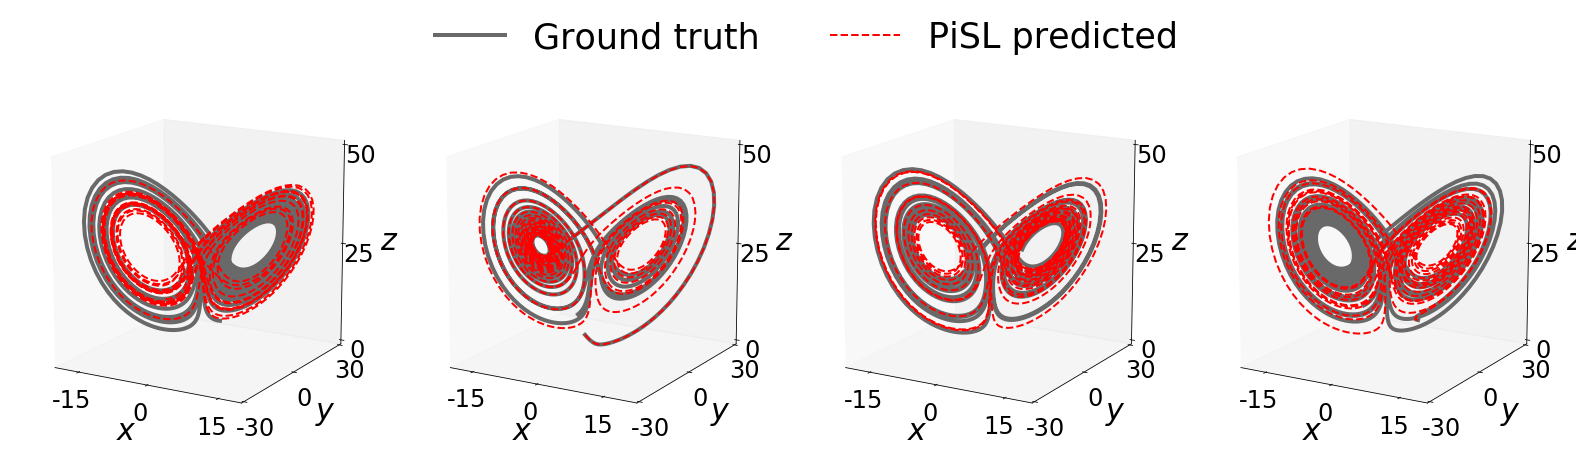

In [92]:
def pred(x_y_z, t):
    x, y, z = x_y_z
    return [eval('-9.999*x + 10.02*y'), eval('27.971*x - 0.999*y - 1.0*x*z'), eval('-2.666*z + 0.998*x*y')]

fig = plt.figure(figsize=(28, 7))
# plt.suptitle("System Response",  y=1.03, fontsize=30)
# Plot results
for s in range(4):

    x0 = x0_lst[s]

    t = np.linspace(0, 20, 2001)
    x_PiSL = integrate.odeint(pred, x0, t)

    ax = fig.add_subplot(1,4,s+1, projection="3d")
    ax.plot(data_true[s][:, 0], data_true[s][:, 1], data_true[s][:, 2], lw=4, c='dimgrey', label='Ground truth')
    ax.plot(x_PiSL[:, 0], x_PiSL[:, 1],x_PiSL[:, 2], '--', lw=2,  c='r', label='PiSL predicted')
    
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    
    ax.set_xlabel('$x$', fontsize=30)
    ax.set_xticks(arange(-15, 16, 15))
    ax.set_xticklabels(arange(-15, 16, 15), fontsize=24)
    ax.set_ylabel('$y$', fontsize=30)
    ax.set_yticks(arange(-30, 31, 30))
    ax.set_yticklabels(arange(-30, 31, 30), fontsize=24) 
    ax.set_zlabel('$z$', fontsize=30)
    ax.set_zticks(arange(0, 51, 25))
    ax.set_zticklabels(arange(0, 51, 25), fontsize=24)
    ax.view_init(15)
    if s == 0: plt.legend(fontsize=35, ncol=2, frameon=False, loc=(1.1,1.00))

plt.subplots_adjust(wspace=0.05, hspace=0.05)
fig.savefig('material\Lorenz_multi_pred.pdf', bbox_inches='tight', pad_inches=0.2)
plt.show()

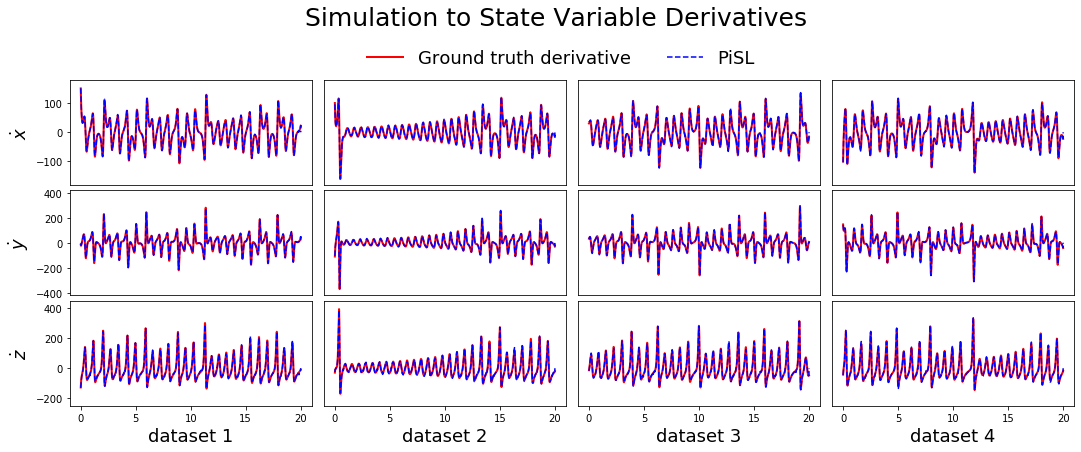

In [26]:
fig = plt.figure(figsize=(18, 6))
plt.suptitle("Simulation to State Variable Derivatives", y=1.05, fontsize=25)
for s in range(4):
    ax = fig.add_subplot(3,4,s+1)
    ax.plot(np.linspace(0, 20, 2001), der_true[s][:, 0], c='r', lw=2, label='Ground truth derivative')
    ax.plot(t_c, np.matmul(basis_dt_c, globals()['P'+str(s+1)].cpu().detach().numpy()[:, 0]), '--', 
             c='b', lw=1.5, label='PiSL')
    ax.axes.yaxis.set_visible(False)
    ax.axes.xaxis.set_visible(False)
    ax.set_ylim(-180, 180)
    if s == 0: 
        plt.legend(fontsize=18, ncol=2, frameon=False, loc=(1.2,1.05))
        ax.set_ylabel('$\dot{x}$', fontsize=18)
        ax.axes.yaxis.set_visible(True)

    ax = fig.add_subplot(3,4,s+5)
    ax.plot(np.linspace(0, 20, 2001), der_true[s][:, 1], c='r', lw=2)
    ax.plot(t_c, np.matmul(basis_dt_c, globals()['P'+str(s+1)].cpu().detach().numpy()[:, 1]), '--', 
             c='b', lw=1.5)
    ax.set_ylabel('$\dot{y}$', fontsize=18)
    ax.axes.yaxis.set_visible(False)
    ax.axes.xaxis.set_visible(False)
    ax.set_ylim(-420, 420)
    if s == 0: 
        ax.set_ylabel('$\dot{y}$', fontsize=18)
        ax.axes.yaxis.set_visible(True)

    ax = fig.add_subplot(3,4,s+9)
    ax.plot(np.linspace(0, 20, 2001), der_true[s][:, 2], c='r', lw=2)
    ax.plot(t_c, np.matmul(basis_dt_c, globals()['P'+str(s+1)].cpu().detach().numpy()[:, 2]), '--', 
             c='b', lw=1.5)
    ax.set_ylabel('$\dot{z}$', fontsize=18)
    ax.set_xlabel('time', fontsize=18)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.set_xlabel('dataset '+str(s+1), fontsize=18)
    ax.axes.xaxis.set_visible(True)
    ax.set_ylim(-250, 450)
    if s == 0: 
        ax.set_ylabel('$\dot{z}$', fontsize=18)
        ax.axes.yaxis.set_visible(True)

plt.subplots_adjust(wspace=0.05, hspace=0.05)
fig.savefig('CBS_pictures\PiSL_multi-data_deriv.pdf', bbox_inches='tight')
plt.show()